# Import Libraries

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from lib_file import lib_path
import re
import contractions
from langdetect import detect
import wordcloud

# Data Loading

In [8]:
df = pd.read_csv("input/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
df.columns = ['sentiment', 'id', 'timestamp', 'query', 'user', 'text']
df.head()

,sentiment,id,timestamp,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Data Preprocessing

In [9]:
df['sentiment'].unique().tolist()

[0, 4]

In [10]:
dict_ = {
    0: 'Negative',
    4: 'Positive'
}

df['sentiment'] = df['sentiment'].map(dict_)

df.head()

,sentiment,id,timestamp,query,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
df['sentiment'].value_counts()

Negative    800000
Positive    800000
Name: sentiment, dtype: int64

In [12]:
df_pos = df.loc[df['sentiment']=='Positive'][:10000]
df_neg = df.loc[df['sentiment']=='Negative'][:10000]

df = pd.concat(objs=[df_pos, df_neg], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,sentiment,id,timestamp,query,user,text
0,Negative,1468249654,Tue Apr 07 00:32:27 PDT 2009,NO_QUERY,GrantWaters,@RebeccaMayne That does sound boring as hell b...
1,Negative,1548856059,Fri Apr 17 22:11:17 PDT 2009,NO_QUERY,AreThree,Crazy snow. Went from mowing to shovelling in...
2,Negative,1468106339,Mon Apr 06 23:44:55 PDT 2009,NO_QUERY,Syph0n,Ugh. still working on project just taking a s...
3,Positive,1468020560,Mon Apr 06 23:17:46 PDT 2009,NO_QUERY,kreativlink,@NOSSOATELIE Thank you dear!
4,Negative,1469035569,Tue Apr 07 04:56:09 PDT 2009,NO_QUERY,kch33,Getting ready to go to meeting.....Yeah!!


In [13]:
df.shape

(20000, 6)

In [14]:
def remove_emoticons(text):
    emoticons_to_remove = [":)", ":(", ":D", ";D", ":*", ":'(", ":/", "O:)", ":P", ":O", "&)", "^_^", ">:O", ":3", ">:(", "8|", "O.o", "-_-", "3:)", "<3", ":V", ":|]", "(^^^)", '<(")']
    for emoticon in emoticons_to_remove:
        text = text.replace(emoticon, '')
    return text

In [15]:
def text_cleaning(text):
    text = remove_emoticons(text)
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # Emojis
                            u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                            u"\U0001F700-\U0001F77F"  # Alphabetic presentation forms
                            u"\U0001F780-\U0001F7FF"  # Geometric shapes
                            u"\U0001F800-\U0001F8FF"  # Miscellaneous symbols"
                            u"\U0001F900-\U0001F9FF"  # Supplemental symbols & pictographs
                            u"\U0001FA00-\U0001FA6F"  # Extended-A
                            u"\U0001FA70-\U0001FAFF"  # Extended-B
                            u"\U0001F004-\U0001F0CF"  # Mahjong tiles
                            u"\U0001F170-\U0001F251"  # Enclosed characters
                            u"\U00020000-\U0002F73F"  # Chinese, Japanese, and Korean characters
                            u"\U000E0000-\U000E007F"  # Tags
                            "]+", flags=re.UNICODE)
    text = re.sub(emoji_pattern, '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'(@\w+|#\w+)', '', text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    try:
        lang = detect(text)
        if lang == 'en':
            return text.lower()
        else:
            return 'empty'
    except:
        return 'empty'

In [16]:
sentences = []
for text in tqdm(df['text'].values):
    sentences.append(text_cleaning(text))

100%|██████████| 20000/20000 [02:56<00:00, 113.61it/s]


In [17]:
df['cleaned_text'] = sentences
df.head()

,sentiment,id,timestamp,query,user,text,cleaned_text
0,Negative,1468249654,Tue Apr 07 00:32:27 PDT 2009,NO_QUERY,GrantWaters,@RebeccaMayne That does sound boring as hell b...,that does sound boring as hell becs
1,Negative,1548856059,Fri Apr 17 22:11:17 PDT 2009,NO_QUERY,AreThree,Crazy snow. Went from mowing to shovelling in...,crazy snow went from mowing to shovelling in ...
2,Negative,1468106339,Mon Apr 06 23:44:55 PDT 2009,NO_QUERY,Syph0n,Ugh. still working on project just taking a s...,ugh still working on project just taking a sm...
3,Positive,1468020560,Mon Apr 06 23:17:46 PDT 2009,NO_QUERY,kreativlink,@NOSSOATELIE Thank you dear!,thank you dear
4,Negative,1469035569,Tue Apr 07 04:56:09 PDT 2009,NO_QUERY,kch33,Getting ready to go to meeting.....Yeah!!,getting ready to go to meetingyeah


In [18]:
df = df.loc[df['cleaned_text'] != 'empty']
df = df.reset_index(drop=True)
df.shape

(18551, 7)

In [19]:
df = df[["cleaned_text", 'sentiment']]
df.head()

,cleaned_text,sentiment
0,that does sound boring as hell becs,Negative
1,crazy snow went from mowing to shovelling in ...,Negative
2,ugh still working on project just taking a sm...,Negative
3,thank you dear,Positive
4,getting ready to go to meetingyeah,Negative


In [20]:
df['sequence_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
df = df.loc[df['sequence_length']>2]
df.head()

,cleaned_text,sentiment,sequence_length
0,that does sound boring as hell becs,Negative,7
1,crazy snow went from mowing to shovelling in ...,Negative,23
2,ugh still working on project just taking a sm...,Negative,10
3,thank you dear,Positive,3
4,getting ready to go to meetingyeah,Negative,6


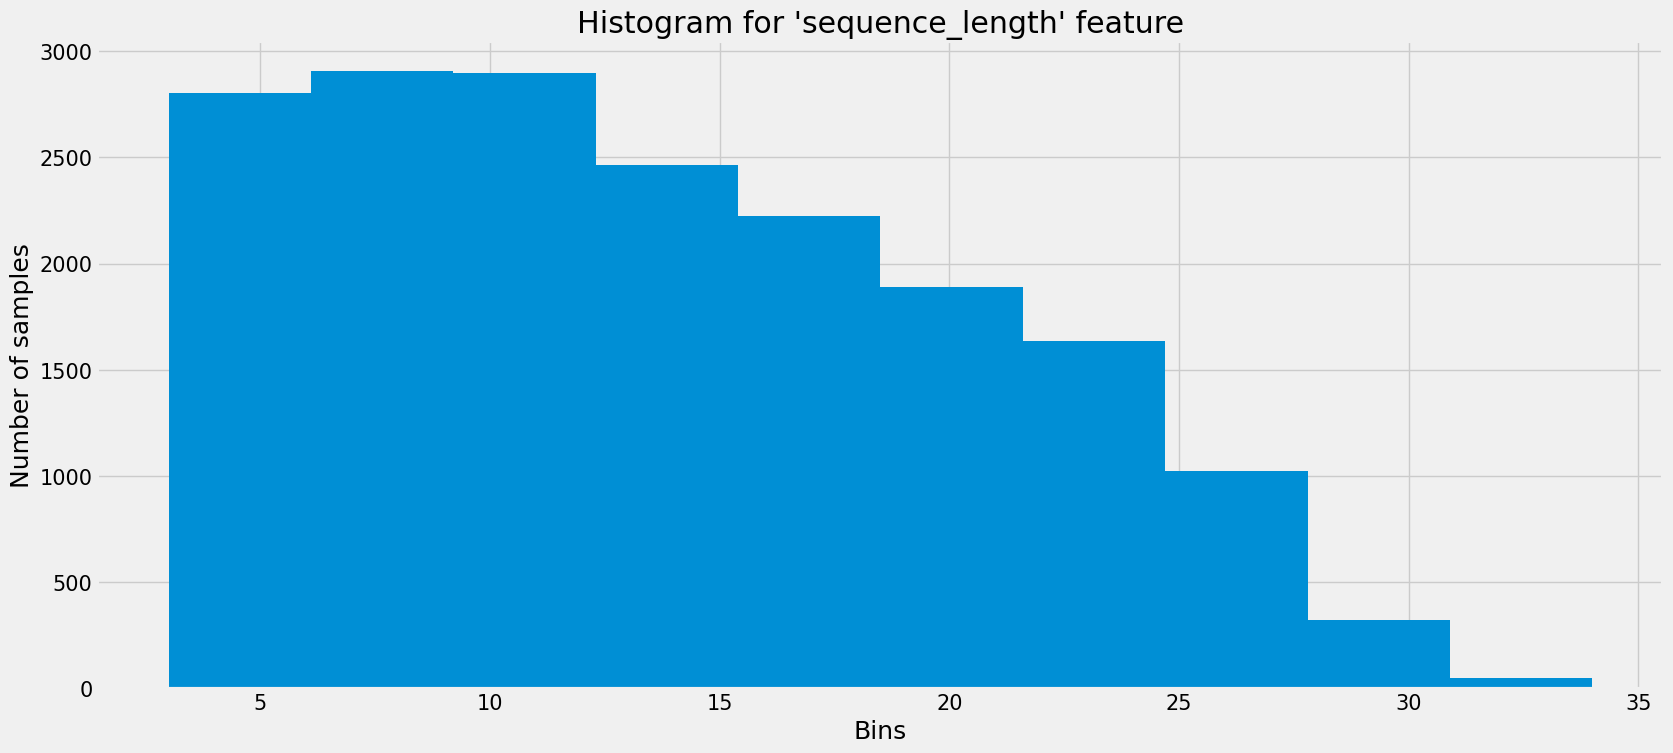

In [21]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(18,8))
    plt.rcParams['font.size'] = 15
    plt.hist(df['sequence_length'].values)
    plt.title(label="Histogram for 'sequence_length' feature")
    plt.xlabel(xlabel='Bins')
    plt.ylabel(ylabel='Number of samples')
    plt.show()

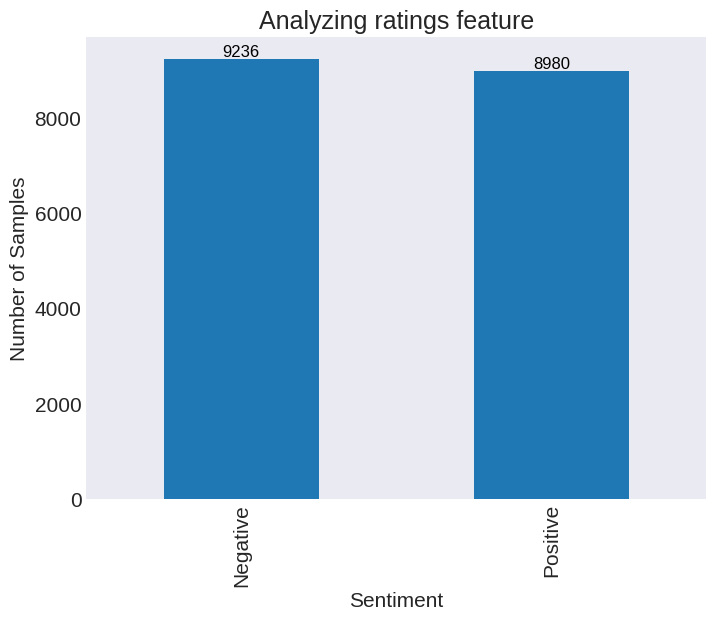

In [22]:
with plt.style.context(style="seaborn-dark"):
    plt.rcParams['font.size'] = 15
    ax = df['sentiment'].value_counts().plot.bar(figsize=(8,6))
    plt.title(label="Analyzing ratings feature")
    plt.xlabel(xlabel="Sentiment")
    plt.ylabel(ylabel="Number of Samples")

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    plt.show()

In [23]:
df.head()

,cleaned_text,sentiment,sequence_length
0,that does sound boring as hell becs,Negative,7
1,crazy snow went from mowing to shovelling in ...,Negative,23
2,ugh still working on project just taking a sm...,Negative,10
3,thank you dear,Positive,3
4,getting ready to go to meetingyeah,Negative,6


In [24]:
df_pos = df.loc[df['sentiment']=='Positive'][:5000]
df_neg = df.loc[df['sentiment']=='Negative'][:5000]

df = pd.concat(objs=[df_pos, df_neg], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,cleaned_text,sentiment,sequence_length
0,that is awsome you might know jay awada,Positive,8
1,quotohh o stop biting me ohhh the humanity o ...,Positive,17
2,in bed now alone lol,Negative,5
3,time to sleep nyt socal see yah in 3 weekshav...,Positive,15
4,true luxury has evolved into something called ...,Positive,18


In [25]:
df.shape

(10000, 3)

In [26]:
df = df.drop(labels='sequence_length', axis=1)
df.head()

,cleaned_text,sentiment
0,that is awsome you might know jay awada,Positive
1,quotohh o stop biting me ohhh the humanity o ...,Positive
2,in bed now alone lol,Negative
3,time to sleep nyt socal see yah in 3 weekshav...,Positive
4,true luxury has evolved into something called ...,Positive


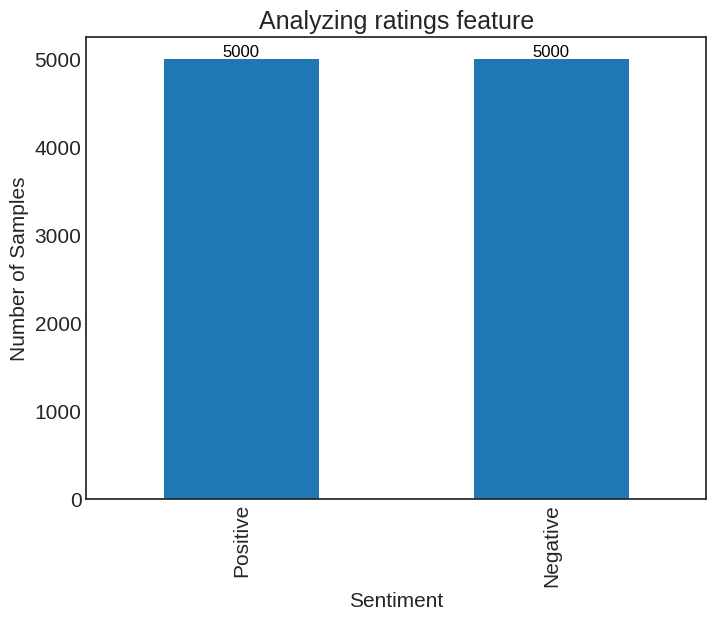

In [27]:
with plt.style.context(style="seaborn-white"):
    plt.rcParams['font.size'] = 15
    ax = df['sentiment'].value_counts().plot.bar(figsize=(8,6))
    plt.title(label="Analyzing ratings feature")
    plt.xlabel(xlabel="Sentiment")
    plt.ylabel(ylabel="Number of Samples")

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    plt.show()

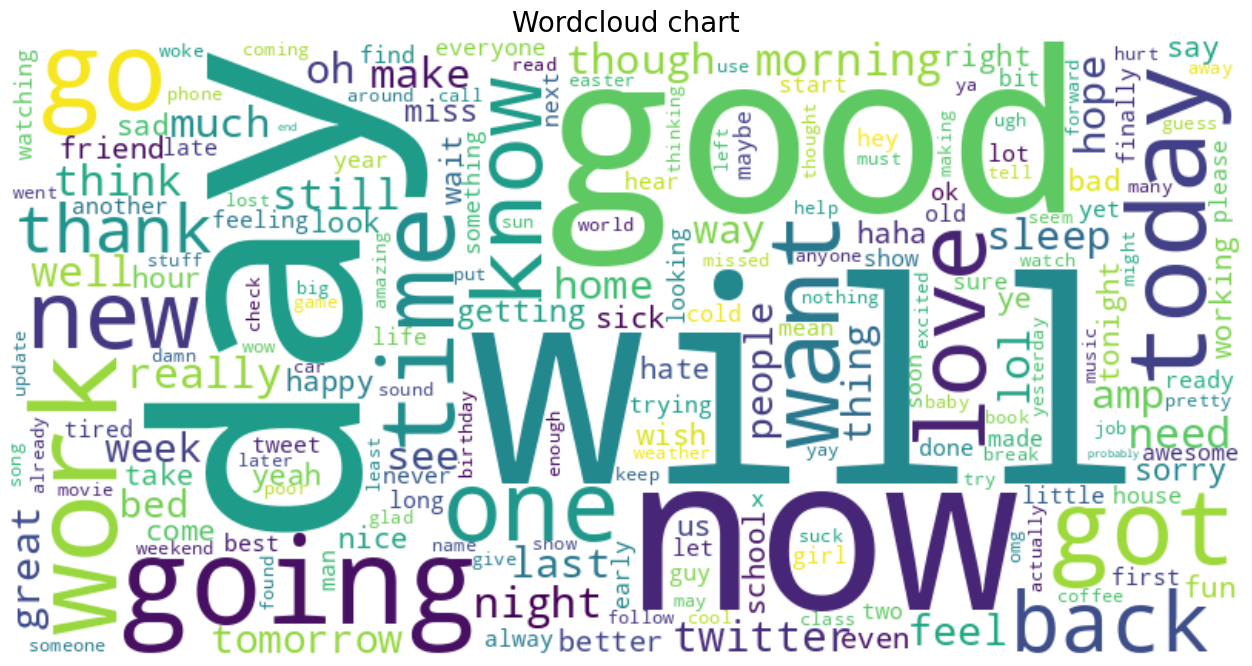

In [28]:
temp_df = df[['cleaned_text']]
temp_df['text'] = temp_df['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
text = ' '.join(temp_df['text'])
wordcloud_obj = wordcloud.WordCloud(width=800, height=400, background_color='white', collocations=False)
wordcloud_image = wordcloud_obj.generate(text)
plt.figure(figsize=(18,8))
plt.title(label="Wordcloud chart", fontsize=20)
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
df.head()

,cleaned_text,sentiment
0,that is awsome you might know jay awada,Positive
1,quotohh o stop biting me ohhh the humanity o ...,Positive
2,in bed now alone lol,Negative
3,time to sleep nyt socal see yah in 3 weekshav...,Positive
4,true luxury has evolved into something called ...,Positive


In [32]:
df.to_csv("cleaned_data.csv", index=False)

---